SC making the NN a pytorch model

In [16]:
print("Sc Vax Classify")

Sc Vax Classify


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif

from itertools import product

import pandas as pd
import numpy as np

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#from imblearn.over_sampling import SMOTE


In [18]:
# get the data
df = pd.read_csv("data/train_val.csv")
df.head()

,ID,tweet,labels
0,1296010336907038720t,@cath__kath AstraZeneca is made with the kidne...,ingredients
1,1336808189677940736t,It begins. Please find safe alternatives to th...,side-effect
2,1329488407307956231t,"@PaolaQP1231 Well, I mean congratulations Covi...",side-effect
3,1364194604459900934t,@BorisJohnson for those of us that do not wish...,mandatory
4,1375938799247765515t,She has been trying to speak out: writing lett...,side-effect rushed


In [19]:
# std defn
num_classes = 2

In [20]:
# split data for each class
attr = [
    "unnecessary",
    "mandatory",
    "pharma",
    "conspiracy",
    "political",
    "country",
    "rushed",
    "ingredients",
    "side-effect",
    "ineffective",
    "religious",
    "none",
]

accuracies = {}
training_accuracy = {}
# split data for each class

# copy the df and modify such that for those rows where the string value of labels column contains 'unnecessary', set the label columnn to 1 else 0
# make a copy of the df and set it to another variable
# df_unnecessary = df.copy()
# df_unnecessary["unnecessary"] = df_unnecessary["labels"].apply(
#     lambda x: 1 if "unnecessary" in x else 0
# )
# copy the df and modify such that for those rows where the string value of labels column contains 'mandatory', set the label columnn to 1 else 0
'''df_mandatory = df.copy()
df_mandatory["mandatory"] = df_mandatory["labels"].apply(
    lambda x: 1 if "mandatory" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'pharma', set the label columnn to 1 else 0
df_pharma = df.copy()
df_pharma["pharma"] = df_pharma["labels"].apply(lambda x: 1 if "pharma" in x else 0)

# copy the df and modify such that for those rows where the string value of labels column contains 'conspiracy', set the label columnn to 1 else 0
df_conspiracy = df.copy()
df_conspiracy["conspiracy"] = df_conspiracy["labels"].apply(
    lambda x: 1 if "conspiracy" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'political', set the label columnn to 1 else 0
df_political = df.copy()
df_political["political"] = df_political["labels"].apply(
    lambda x: 1 if "political" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'country', set the label columnn to 1 else 0
df_country = df.copy()
df_country["country"] = df_country["labels"].apply(lambda x: 1 if "country" in x else 0)

# copy the df and modify such that for those rows where the string value of labels column contains 'rushed', set the label columnn to 1 else 0
df_rushed = df.copy()
df_rushed["rushed"] = df_rushed["labels"].apply(lambda x: 1 if "rushed" in x else 0)

# copy the df and modify such that for those rows where the string value of labels column contains 'ingredients', set the label columnn to 1 else 0
df_ingredients = df.copy()
df_ingredients["ingredients"] = df_ingredients["labels"].apply(
    lambda x: 1 if "ingredients" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'side-effect', set the label columnn to 1 else 0
df_side_effect = df.copy()
df_side_effect["side-effect"] = df_side_effect["labels"].apply(
    lambda x: 1 if "side-effect" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'ineffective', set the label columnn to 1 else 0
df_ineffective = df.copy()
df_ineffective["ineffective"] = df_ineffective["labels"].apply(
    lambda x: 1 if "ineffective" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'religious', set the label columnn to 1 else 0
df_religious = df.copy()
df_religious["religious"] = df_religious["labels"].apply(
    lambda x: 1 if "religious" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'none', set the label columnn to 1 else 0
df_none = df.copy()
df_none["none"] = df_none["labels"].apply(lambda x: 1 if "none" in x else 0)'''

df_unnecessary = pd.read_csv("data/df_unnecessary.csv")
df_mandatory = pd.read_csv("data/df_mandatory.csv")
df_pharma = pd.read_csv("data/df_pharma.csv")
df_conspiracy = pd.read_csv("data/df_conspiracy.csv")
df_political = pd.read_csv("data/df_political.csv")
df_country = pd.read_csv("data/df_country.csv")
df_rushed = pd.read_csv("data/df_rushed.csv")
df_ingredients = pd.read_csv("data/df_ingredients.csv")
df_side_effect = pd.read_csv("data/df_side_effect.csv")
df_ineffective = pd.read_csv("data/df_ineffective.csv")
df_religious = pd.read_csv("data/df_religious.csv")
df_none = pd.read_csv("data/df_none.csv")

df_all = [
    df_unnecessary,
    df_mandatory,
    df_pharma,
    df_conspiracy,
    df_political,
    df_country,
    df_rushed,
    df_ingredients,
    df_side_effect,
    df_ineffective,
    df_religious,
    df_none,
]

#shuffle each dataset in df_all
for i in range(len(df_all)):
    df_all[i] = df_all[i].sample(frac=1).reset_index(drop=True)


In [21]:
#print 5 positive and 5 negative samples from df_religious
#for i in (df_religious.loc()):
#    print(i) if (i['religious'] == 1) else (print(""))

In [22]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    # Vectorization parameters
    # Range (inclusive) of n-gram sizes for tokenizing text.
    NGRAM_RANGE = (1, 2)

    # Limit on the number of features. We use the top 20K features.
    TOP_K = 20000

    # Whether text should be split into word or character n-grams.
    # One of 'word', 'char'.
    TOKEN_MODE = "word"


    # Minimum document/corpus frequency below which a token will be discarded.
    MIN_DOCUMENT_FREQUENCY = 2
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
        "ngram_range": NGRAM_RANGE,  # Use 1-grams + 2-grams.
        "dtype": np.float64,
        "strip_accents": "unicode",
        "decode_error": "replace",
        "analyzer": TOKEN_MODE,  # Split text into word tokens.
        "min_df": MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)
    #x_pred = vectorizer.transform(pred_text)
    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype("float32")
    x_val = selector.transform(x_val).astype("float32")
    return x_train, x_val

In [23]:
def get_accuracy(model, x_val, y_val):
    # Set the model to evaluation mode.
    model.eval()

    # Compute the predictions on the validation set.
    with torch.no_grad():
        logits = model(x_val)
        predictions = torch.argmax(logits, dim=1)

    # Compute the accuracy of the model on the validation set.
    correct_predictions = torch.eq(predictions, y_val).sum().item()
    total_predictions = y_val.shape[0]
    accuracy = correct_predictions / total_predictions

    return accuracy

In [24]:
from sklearn.metrics import recall_score

def get_recall(model, x_val, y_val):
    # Set the model to evaluation mode.
    model.eval()

    # Compute the predictions on the validation set.
    with torch.no_grad():
        logits = model(x_val)
        predictions = torch.argmax(logits, dim=1)

    # Compute the recall of the model on the validation set.
    recall = recall_score(y_val, predictions, average="macro")

    return recall

In [25]:
from sklearn.metrics import precision_score

def get_precision(model, x_val, y_val):
    # Set the model to evaluation mode.
    model.eval()

    # Compute the predictions on the validation set.
    with torch.no_grad():
        logits = model(x_val)
        predictions = torch.argmax(logits, dim=1)

    # Compute the precision of the model on the validation set.
    precision = precision_score(y_val, predictions, average="macro")

    return precision

In [26]:
# pytorch nn model
import torch.nn as nn


class MLP(nn.Module):
    def __init__(self, layers, units, dropout_rate, input_shape, num_classes):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(input_shape, units)
        self.relu1 = nn.ReLU()
        self.layers = nn.ModuleList()
        for _ in range(layers - 1):
            self.layers.append(nn.Linear(units, units))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))
        self.fc2 = nn.Linear(units, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu1(x)
        for layer in self.layers:
            x = layer(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

we have a bunch of options in front of us: binary chain, ensembling (best but maybe complex to choose b/w ensembling methods), power set (not rec)

In [27]:
def train_ngram_model(
    data,
    name,
    learning_rate=1e-4,
    epochs=10,
    batch_size=128,
    layers=2,
    units=64,
    dropout_rate=0.4,
):
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Vectorize texts.
    x_train, x_val = ngram_vectorize(train_texts, train_labels, val_texts)
    #print(x_train.shape)
    x_train_int = int(x_train.shape[0]), int(x_train.shape[1])
    #Create model instance.
    model = MLP(
        layers=layers,
        units=units,
        dropout_rate=dropout_rate,
        input_shape=x_train_int[1],
        num_classes=2,
    )

    
    # Compile model with learning parameters.
    if num_classes == 2:
        loss = "binary_crossentropy"
    else:
        loss = "sparse_categorical_crossentropy"

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    criterion = nn.BCELoss()


    x_train = torch.from_numpy(x_train.toarray()).float()
    train_tuple = torch.tensor(train_labels.values)
    y_train = F.one_hot(train_tuple, num_classes=2).float()  

    # Create a TensorDataset from your training data.
    train_dataset = TensorDataset(x_train, y_train)

    # Create a DataLoader from the TensorDataset.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    #callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)]

    num_epochs = epochs

    model = nn.DataParallel(model)
    device = torch.device("cpu")
    model.to(device)

    try:
        a = 5/0
        model.load_state_dict(torch.load("models/model" + name + ".pt"))
    except Exception as e:
        print(e)
        for epoch in range(num_epochs):
            model.train()  # Set the model in training mode
            total_step = len(train_loader)
            
            for i, (batch_data, batch_labels) in enumerate(train_loader):
                # Move batch data and labels to the specified device
                batch_data = batch_data.to(device)
                batch_labels = batch_labels.to(device)

                # Forward pass
                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Print or log training progress
                print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        torch.save(model.state_dict(), "models/model" + name + ".pt")
        


    first_row = x_val.toarray()[0]

    x_val_tensor = torch.from_numpy(x_val.toarray()).float()
    y_val_tensor = torch.tensor(val_labels.values)
    accuracy = get_accuracy(model, x_val_tensor, y_val_tensor)

    # Print the accuracy.
    #print("Validation accuracy:", accuracy)
    accuracies[name] = accuracy

    #print the recall
    print("recall", get_recall(model, x_val_tensor, y_val_tensor))
    
    #print the precision
    print("precision", get_precision(model, x_val_tensor, y_val_tensor))
    
    #print the training accuracry
    training_accuracy[name] = get_accuracy(model, x_train, train_tuple)
    #print("training accuracy", get_accuracy(model, x_train, train_tuple))
    
    #print("x_train_int[1]")
    first_row_tensor = torch.tensor(first_row)

    train_labels_list = train_labels.tolist()

    return accuracy

    '''misses = 0
    print("training")
    for ind, val in enumerate(train_labels_list):
        if True:
            first_row = x_val.toarray()[ind]
            first_row_tensor = torch.tensor(first_row)

            model.eval()
            with torch.no_grad():
                prediction = model.forward(first_row_tensor)
            #print('ac: ', train_labels_list[ind])
            prediction = prediction.tolist().index(max(prediction.tolist()))
            #print('pr: ', prediction)
            #print('\n')
            pred_dict[name] = prediction
            # if prediction != val:
            #     misses += 1

            # if ind > 1500:
            #     break

    print("misses", misses/1500)     '''

    # model.eval()
    # with torch.no_grad():
    #     prediction = model.forward(torch.from_numpy(x_pred.toarray()))


    

In [28]:
def predict(model, train_texts, train_labels, val_texts, name):
    # Vectorizing the text data using your custom ngram_vectorize function
    #set model to eval
    model.eval()
    x_val = ngram_vectorize(train_texts, train_labels, val_texts, name)[1]

    # Predicting the validation labels
    val_predictions = model.predict(x_val)

    # Calculating the accuracy of the model on the validation data
    return val_predictions

In [29]:
# Defining a custom grid search function
def custom_grid_search(df, epochs_range, learning_rate_range, batch_size_range, dropout_rate_range, layers, units, name):
    best_accuracy = 0.0
    best_hyperparameters = None

    # Iterate through all combinations of hyperparameters
    for epochs, learning_rate, batch_size, dropout_rate, layer, unit in product(epochs_range, learning_rate_range, batch_size_range, dropout_rate_range, layers, units):
        # Splitting the data (Assuming the last column is the label)
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            df.iloc[:, 1], df.iloc[:, -1], test_size=0.2, random_state=42
        )
        data = (train_texts, train_labels), (val_texts, val_labels)

        # Train the model and get accuracy (Using the existing training function in your code)
        accuracy = train_ngram_model(
            name = name,
            data=data,
            learning_rate=learning_rate,
            epochs=epochs,
            batch_size=batch_size,
            dropout_rate=dropout_rate,
            layers=layer,
            units=unit
        )

        accuracy = accuracies[name]

        # Update best hyperparameters if this accuracy is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = {
                'epochs': epochs,
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'dropout_rate': dropout_rate
            }

    return best_hyperparameters, best_accuracy

In [ ]:
global pred_dict
pred_dict = {}
pred_list = []
for i in attr:
    pred_dict[i] = []

epochs_range = range(1, 33)
learning_rate_range = [1e-2, 1e-4]
batch_size_range = [32, 64, 128]
dropout_rate_range = [0.2, 0.3, 0.4, 0.5]
layers = [2,3]
units  = [8, 16, 32, 64]
hp, acc = [], []

for ind, i in enumerate(df_all[:1]):
    #Split the data into training and testing sets
#i, ind = df_all[0], 0
    # print(attr[ind])
    # train_texts, val_texts, train_labels, val_labels = train_test_split(
    #     i.iloc[:, 1], i.iloc[:, -1], test_size=0.2, random_state=42
    # )
    # data = (train_texts, train_labels), (val_texts, val_labels)

    # train_ngram_model(data, name=attr[ind])
    a = custom_grid_search(i, epochs_range, learning_rate_range, batch_size_range, dropout_rate_range, layers, units,attr[ind])
    hp.append(a[0])
    acc.append(a[1])


print(hp, acc)

In [ ]:
print(accuracies)
print(attr)
print(training_accuracy)
print(hp, acc)

{'unnecessary': 0.657439446366782, 'mandatory': 0.7484076433121019, 'pharma': 0.7509803921568627}
['unnecessary', 'mandatory', 'pharma', 'conspiracy', 'political', 'country', 'rushed', 'ingredients', 'side-effect', 'ineffective', 'religious', 'none']
{'unnecessary': 0.8147186147186147, 'mandatory': 0.981629392971246, 'pharma': 1.0}
[{'epochs': 22, 'learning_rate': 0.0001, 'batch_size': 64, 'dropout_rate': 0.5}, {'epochs': 7, 'learning_rate': 0.01, 'batch_size': 32, 'dropout_rate': 0.5}] [0.8235294117647058, 0.7961783439490446]


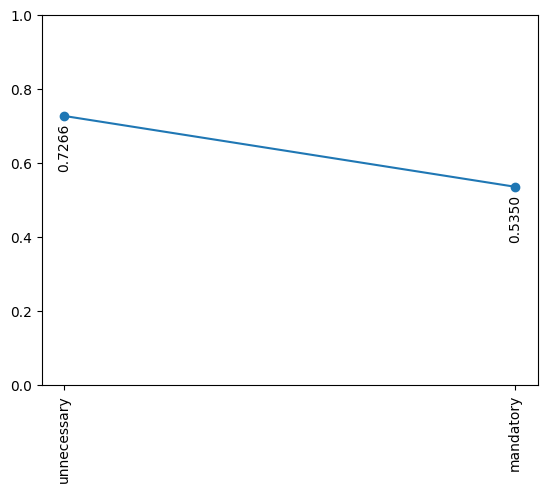

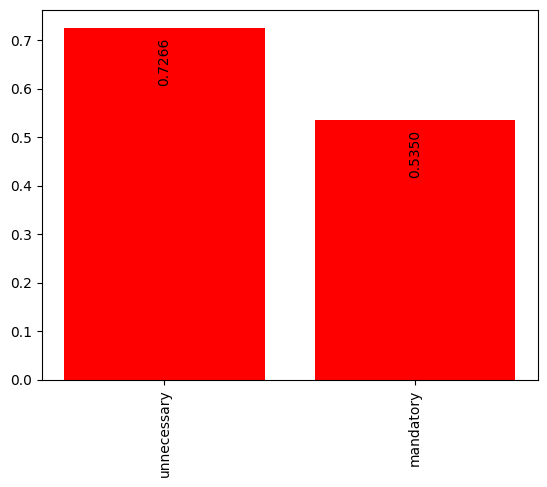

In [ ]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 7))
x = range(len(accuracies))
X = list(accuracies.keys())
y = list(accuracies.values())
plt.plot(X, y, marker='o')
plt.xticks(x, X, rotation="vertical")
plt.ylim([0, 1])
for i in range(len(x)):
    plt.text(x[i], y[i]-0.02, f'{y[i]:.4f}', ha='center', va='top', rotation='vertical')
plt.show()
plt.bar(X, y, color='red')
plt.xticks(x, X, rotation="vertical")
for i in range(len(x)):
    plt.text(x[i], y[i]-0.02, f'{y[i]:.4f}', ha='center', va='top', rotation='vertical')
plt.show()

TODO: make traning parallel
TODO: account for data imbalance
TODO: ramp up epochs to max and take top 20k features again (change the df_min)

[1444, 1566, 2546, 974, 1252, 402, 2952, 872, 9921, 3344, 128, 1258]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (12,).

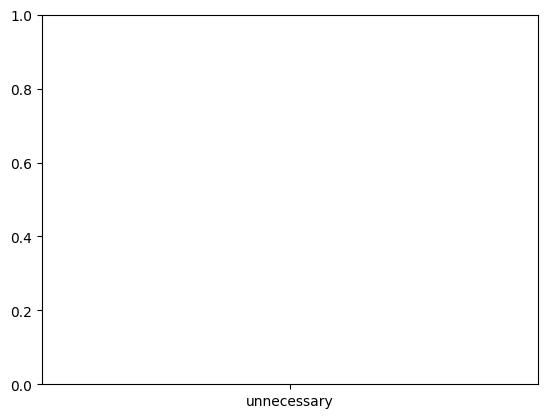

In [ ]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 7))
x = range(len(training_accuracy))
X = list(training_accuracy.keys())
y = list(training_accuracy.values())

df_sizes = [len(i) for i in df_all]
print(df_sizes)
#show the values of df_sizes in green
plt.bar(X, df_sizes, color='green')
plt.plot(X, y, marker='o')
plt.xticks(x, X, rotation="vertical")
plt.ylim([0, 1])
for i in range(len(x)):
    plt.text(x[i], y[i]-0.02, f'{y[i]:.4f}', ha='center', va='top', rotation='vertical')
plt.show()
plt.bar(X, y, color='red')
plt.xticks(x, X, rotation="vertical")
for i in range(len(x)):
    plt.text(x[i], y[i]-0.02, f'{y[i]:.4f}', ha='center', va='top', rotation='vertical')
plt.show()

In [ ]:
# pred = ["vaccines are unnessecary and cause autism"]

# # Vectorize the string
# x_train, pred = ngram_vectorize(df_all[0].iloc[:, 1], df_all[0].iloc[:, -1],pred)
# pred_int = int(pred.shape[0]), int(pred.shape[1])

# pred = pred.toarray()
# print(pred.shape)

# # # Calculate the number of zeros to add
# # desired_length = 2000
# # num_zeros = desired_length - pred.shape[0]

# # # Perform padding
# # padded_vector = np.pad(pred, ((0, num_zeros), (0, 0)), 'constant')

# # # Reshape the padded vector
# # reshaped_vector = padded_vector.reshape((desired_length, 1))

# # Load the model
# model = MLP(
#     layers=2,
#     units=64,
#     dropout_rate=0.2,
#     input_shape=2000,
#     num_classes=2,
# )

# model = nn.DataParallel(model)
# device = torch.device("cpu")
# model.to(device)

# # Load the weights
# model.load_state_dict(torch.load('models/modelunnecessary.pt'))

# # Convert the reshaped_vector to a tensor
# pred_tensor = torch.from_numpy(pred).float()

# # Feed the tensor into the model
# model.eval()
# with torch.no_grad():
#     prediction = model.forward(pred_tensor)

# # Print the prediction
# print(prediction.argmax().item())

In [ ]:
# pred = ["vaccines are useful"]

# # Vectorize the string
# x_train, pred = ngram_vectorize(df_all[0].iloc[:, 1], df_all[0].iloc[:, -1],pred)
# pred_int = int(pred.shape[0]), int(pred.shape[1])

# pred = pred.toarray()
# print(pred.shape)

# # # Calculate the number of zeros to add
# # desired_length = 2000
# # num_zeros = desired_length - pred.shape[0]

# # # Perform padding
# # padded_vector = np.pad(pred, ((0, num_zeros), (0, 0)), 'constant')

# # # Reshape the padded vector
# # reshaped_vector = padded_vector.reshape((desired_length, 1))

# # Load the model
# model = MLP(
#     layers=2,
#     units=64,
#     dropout_rate=0.2,
#     input_shape=2000,
#     num_classes=2,
# )

# model = nn.DataParallel(model)
# device = torch.device("cpu")
# model.to(device)

# # Load the weights
# model.load_state_dict(torch.load('models/modelunnecessary.pt'))

# # Convert the reshaped_vector to a tensor
# pred_tensor = torch.from_numpy(pred).float()

# # Feed the tensor into the model
# model.eval()
# with torch.no_grad():
#     prediction = model.forward(pred_tensor)

# # Print the prediction
# print(prediction.argmax().item())